Importing all the libraries

In [1]:
# Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from datetime import timedelta

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import plotly.graph_objects as go

Imports all the necessary Python libraries for data handling, modeling, metrics, and visualization.

Loading the scaler and data

In [2]:

#Load Data and Scaler

scaled_df = pd.read_csv(r'C:\Users\allif\Downloads\Crypto_stocks\data\processed\scaled_predictive_coins.csv', parse_dates=['Date'])

scaled_df.head()

# removing null values
scaled_df = scaled_df.dropna()

#Loading the minmax scaler for inverse transformation
scaler = joblib.load(r'C:\Users\allif\Downloads\Crypto_stocks\notebooks\minmax_scaler_close_prices.pkl')

Loads the scaled multivariate dataset and the pre-fitted MinMax scaler used for inverse transforming the predictions back to original values.

In [3]:
scaled_df.head()# defining coins and columns

,Date,BTC_close_scaled,ETH_close_scaled,LTC_close_scaled,Gold_close_scaled,BTC_close_logret_scaled,ETH_close_logret_scaled,LTC_close_logret_scaled,Gold_close_logret_scaled
1,2020-08-29,0.012194,0.017367,0.040628,0.184812,0.468048,0.597519,0.624911,0.453046
2,2020-08-30,0.014427,0.024117,0.057795,0.194317,0.544709,0.712650,0.771841,0.637246
3,2020-08-31,0.013866,0.025198,0.052082,0.188633,0.468147,0.601679,0.590747,0.471003
4,2020-09-01,0.016347,0.034471,0.057215,0.193862,0.550350,0.745522,0.674535,0.590320
5,2020-09-02,0.011490,0.026470,0.043788,0.181227,0.350915,0.440990,0.528530,0.394481


In [4]:
# Define Coins and Columns ---

coins = {
    "BTC": {'col': 'BTC_close_scaled'},
    "ETH": {'col': 'ETH_close_scaled'},
    "LTC": {'col': 'LTC_close_scaled'},
    "Gold": {'col': 'Gold_close_scaled'},
}
feature_cols = [
    'BTC_close_scaled', 'ETH_close_scaled', 'LTC_close_scaled', 'Gold_close_scaled',
    'BTC_close_logret_scaled', 'ETH_close_logret_scaled', 'LTC_close_logret_scaled', 'Gold_close_logret_scaled'
]
lookback = 30
forecast_horizon = 14

In [5]:
# Sliding Window Function
def create_sliding_window(df, lookback, forecast_horizon, feature_cols, target_col):
    X, Y = [], []
    for i in range(len(df) - lookback - forecast_horizon + 1):
        X.append(df[feature_cols].iloc[i:i+lookback].values)
        Y.append(df[target_col].iloc[i+lookback:i+lookback+forecast_horizon].values)
    return np.array(X), np.array(Y)

Creates time series “windows” so the model can use a fixed number of past days (lookback) to predict the next sequence of prices (forecast horizon).

In [6]:
# Inverse Scaling Helper
def inverse_close(scaled_arr, scaler, col_index):
    scaled_arr = np.array(scaled_arr)
    flat = scaled_arr.reshape(-1)
    arr = np.zeros((flat.shape[0], scaler.n_features_in_))
    arr[:, col_index] = flat
    inv = scaler.inverse_transform(arr)[:, col_index]
    return inv.reshape(scaled_arr.shape)

Transforms model predictions (which are scaled) back to original close price values using the MinMax scaler.

In [7]:
# ED-LSTM Model Builder
def build_ed_lstm_model(lstm_units=64, dropout=0.2, lr=0.001):
    # Encoder
    encoder_inputs = Input(shape=(lookback, len(feature_cols)))
    encoder_lstm = LSTM(lstm_units, dropout=dropout, return_state=True)
    _, state_h, state_c = encoder_lstm(encoder_inputs)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = RepeatVector(forecast_horizon)(state_h)
    decoder_lstm = LSTM(lstm_units, dropout=dropout, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    outputs = TimeDistributed(Dense(1))(decoder_outputs)

    model = Model(encoder_inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model


 Builds an Encoder-Decoder LSTM model for sequence-to-sequence prediction (multistep forecasting)


====== Processing BTC ======


C:\Users\allif\AppData\Local\Temp\ipykernel_1784\3011698548.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=build_ed_lstm_model, verbose=0)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=32; total time=  13.7s
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=32; total time=  15.5s
[CV] END batch_size=16, dropout=0.1, epochs=10, lstm_units=32; total time=  19.0s
[CV] END batch_size=32, dropout=0.2, epochs=15, lstm_units=64; total time=  11.0s
[CV] END batch_size=32, dropout=0.2, epochs=15, lstm_units=64; total time=  16.3s
[CV] END batch_size=32, dropout=0.2, epochs=15, lstm_units=64; total time=  19.7s
[CV] END batch_size=32, dropout=0.2, epochs=10, lstm_units=64; total time=  10.4s
[CV] END batch_size=32, dropout=0.2, epochs=10, lstm_units=64; total time=  12.7s
[CV] END batch_size=32, dropout=0.2, epochs=10, lstm_units=64; total time=  18.5s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=64; total time=  13.0s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=64; total time=  19.1s
[CV] END batch_size=32, dropout=0.1, e

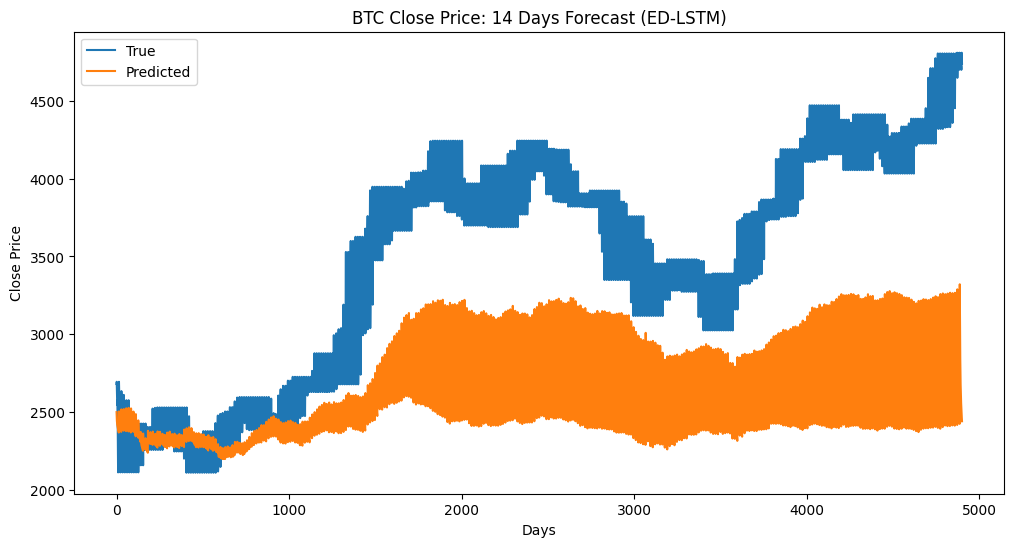

Saved ED-LSTM model for BTC

====== Processing ETH ======


C:\Users\allif\AppData\Local\Temp\ipykernel_1784\3011698548.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=build_ed_lstm_model, verbose=0)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=32; total time=   8.6s
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=32; total time=  10.6s
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=32; total time=  14.6s
[CV] END batch_size=16, dropout=0.1, epochs=15, lstm_units=64; total time=  17.7s
[CV] END batch_size=16, dropout=0.1, epochs=15, lstm_units=64; total time=  26.8s
[CV] END batch_size=16, dropout=0.1, epochs=15, lstm_units=64; total time=  39.8s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=64; total time=  15.6s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=64; total time=  20.3s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=64; total time=  23.0s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=32; total time=  11.1s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=32; total time=  17.5s
[CV] END batch_size=32, dropout=0.1, e

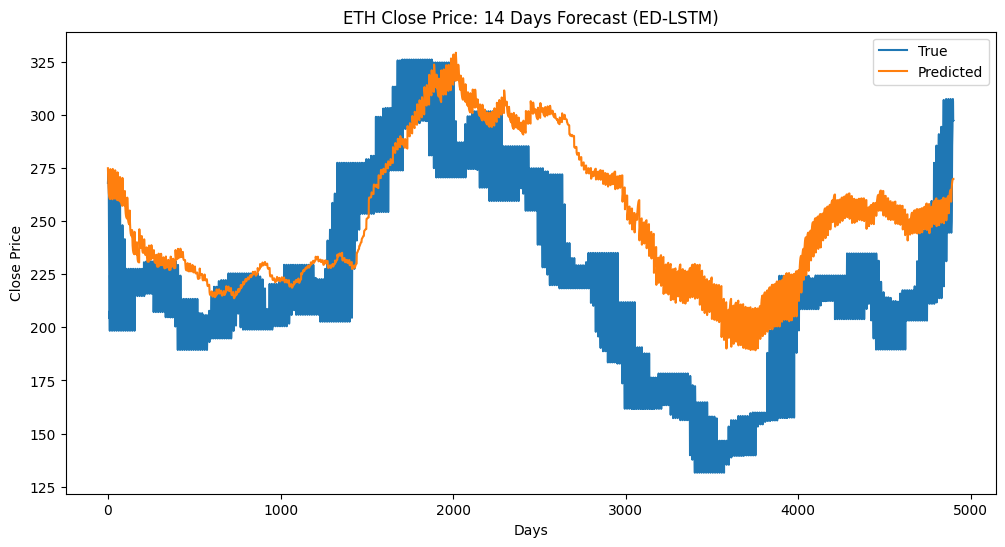

Saved ED-LSTM model for ETH

====== Processing LTC ======


C:\Users\allif\AppData\Local\Temp\ipykernel_1784\3011698548.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=build_ed_lstm_model, verbose=0)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=64; total time=  15.4s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=64; total time=  22.9s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=64; total time= 1.1min
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=32; total time=  24.8s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=32; total time=  32.1s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=32; total time=  35.3s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=64; total time=  27.9s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=64; total time=  29.5s
[CV] END batch_size=32, dropout=0.1, epochs=15, lstm_units=64; total time=  34.2s
[CV] END batch_size=32, dropout=0.2, epochs=15, lstm_units=32; total time=  15.7s
[CV] END batch_size=32, dropout=0.2, epochs=15, lstm_units=32; total time=  21.4s
[CV] END batch_size=32, dropout=0.2, e

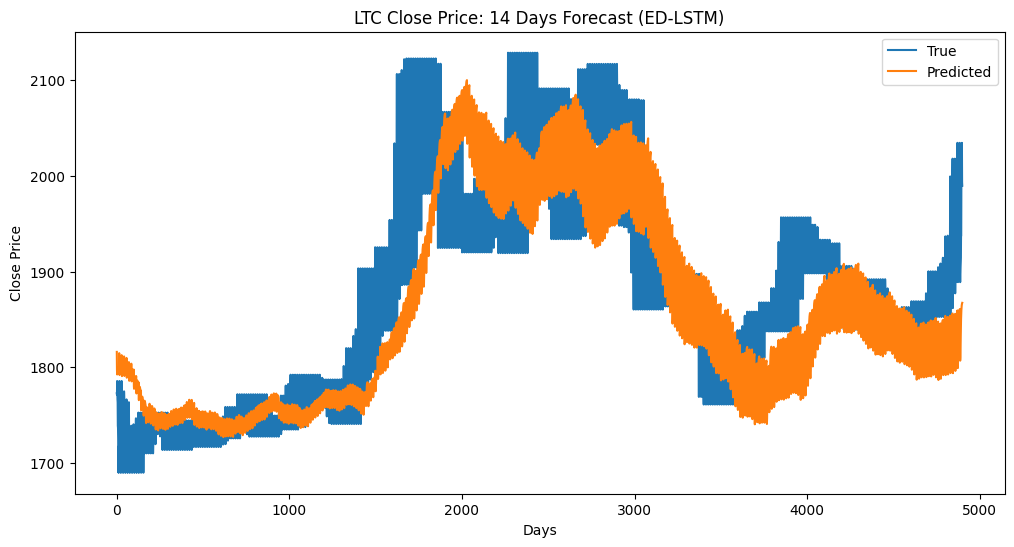

Saved ED-LSTM model for LTC

====== Processing Gold ======


C:\Users\allif\AppData\Local\Temp\ipykernel_1784\3011698548.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = KerasRegressor(build_fn=build_ed_lstm_model, verbose=0)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=32; total time=  12.2s
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=32; total time=  19.8s
[CV] END batch_size=32, dropout=0.1, epochs=10, lstm_units=32; total time=  21.0s
[CV] END batch_size=32, dropout=0.2, epochs=15, lstm_units=32; total time=  14.2s
[CV] END batch_size=32, dropout=0.2, epochs=15, lstm_units=32; total time=  23.4s
[CV] END batch_size=32, dropout=0.2, epochs=15, lstm_units=32; total time=  30.4s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=32; total time=  17.4s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=32; total time=  24.4s
[CV] END batch_size=16, dropout=0.2, epochs=10, lstm_units=32; total time=  52.4s
[CV] END batch_size=32, dropout=0.2, epochs=10, lstm_units=64; total time=  21.7s
[CV] END batch_size=32, dropout=0.2, epochs=10, lstm_units=64; total time=  16.8s
[CV] END batch_size=32, dropout=0.2, e

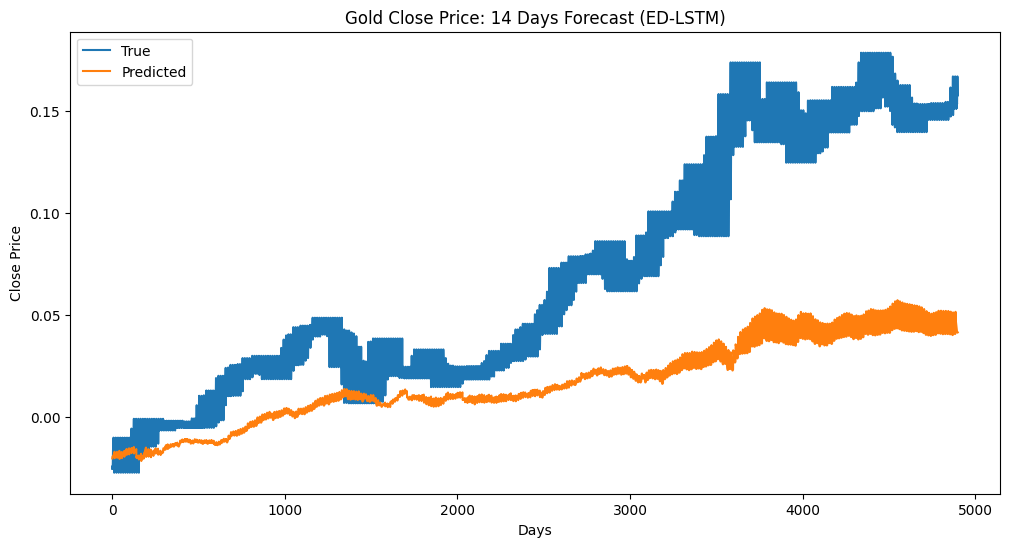

Saved ED-LSTM model for Gold


In [10]:
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Training and Hyperparameter Search
for coin, info in coins.items():
    print(f"\n====== Processing {coin} ======")
    target_col = info['col']
    col_index = scaled_df.columns.get_loc(target_col)
    
    X, Y = create_sliding_window(scaled_df, lookback, forecast_horizon, feature_cols, target_col)
    Y = Y.reshape(Y.shape[0], forecast_horizon, 1)
    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]

    # Hyperparameter tuning
    keras_reg = KerasRegressor(build_fn=build_ed_lstm_model, verbose=0)
    param_dist = {
        "lstm_units": [32, 64],
        "dropout": [0.1, 0.2],
        "batch_size": [16, 32],
        "epochs": [10, 15],
    }
    tscv = TimeSeriesSplit(n_splits=3)
    search = RandomizedSearchCV(
        keras_reg, param_distributions=param_dist, n_iter=4,
        cv=tscv, verbose=2, n_jobs=1
    )
    search.fit(X_train, Y_train)
    print(f"Best hyperparameters for {coin}: {search.best_params_}")

    # Retrain the best model
    best = search.best_params_
    model = build_ed_lstm_model(
        lstm_units=best["lstm_units"],
        dropout=best["dropout"],
        lr=0.001
    )
    model.fit(
        X_train, Y_train,
        epochs=best["epochs"],
        batch_size=best["batch_size"],
        verbose=2
    )

    # Evaluate
    y_pred = model.predict(X_test)
    true_unscaled = inverse_close(Y_test.squeeze(-1), scaler, col_index)
    pred_unscaled = inverse_close(y_pred.squeeze(-1), scaler, col_index)
    mae = mean_absolute_error(true_unscaled, pred_unscaled)
    rmse = mean_squared_error(true_unscaled, pred_unscaled, squared=False)
    r2 = r2_score(true_unscaled, pred_unscaled)
    print(f"{coin} MAE: {mae:.2f} | RMSE: {rmse:.2f} | R2: {r2:.4f}")

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(true_unscaled.flatten(), label='True')
    plt.plot(pred_unscaled.flatten(), label='Predicted')
    plt.title(f"{coin} Close Price: 14 Days Forecast (ED-LSTM)")
    plt.xlabel('Days')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Save model
    model.save(f"{coin.lower()}_ed_lstm_14d_model.h5")
    print(f"Saved ED-LSTM model for {coin}")
